In [1]:
%matplotlib inline

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append('./')
from dataset import tuSimpleDataset
from torch.utils.data import DataLoader
from models.segnet import SegNet
from models.enet import ENet
from models.resnet38 import ResNet38
from models.bisenet import BiSeNet
from models.enet_k import ENet as ENet_k
from models.resnet38_k import ResNet38 as ResNet38_k
from scipy import ndimage as ndi
from sklearn.cluster import DBSCAN

INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 2
BATCH_SIZE = 5
SIZE = [224, 224]

In [2]:
# refer from : https://github.com/nyoki-mtl/pytorch-discriminative-loss/blob/master/src/utils.py
def coloring(mask):
    ins_color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    n_ins = len(np.unique(mask)) - 1
    colors = [plt.cm.gist_rainbow(each) for each in np.linspace(0, 1, n_ins)]
    for i in range(n_ins):
        ins_color_img[mask == i + 1] =\
            (np.array(colors[i][:3]) * 255).astype(np.uint8)
    return ins_color_img

def gen_instance_mask(sem_pred, ins_pred, n_obj):
    embeddings = ins_pred[:, sem_pred].transpose(1, 0)
#     clustering = KMeans(n_obj).fit(embeddings)
    clustering = DBSCAN(eps=0.05).fit(embeddings)
    labels = clustering.labels_

    instance_mask = np.zeros_like(sem_pred, dtype=np.uint8)
    for i in range(n_obj):
        lbl = np.zeros_like(labels, dtype=np.uint8)
        lbl[labels == i] = i + 1
        instance_mask[sem_pred] += lbl

    return instance_mask

In [3]:
def test_model(filename = '_model_best', shuffle=False, model = 'enet', data_part = 'test', split_train=False, data_num=10, seed=None):
    if data_part=='train':
        test_path = '../TUSimple/train_set'
    else:
        test_path = '../TUSimple/test_set'
    # MODEL_PATH = '../model_best_enet.pth'
    MODEL_PATH = f'../{filename}.pth'
    test_dataset = tuSimpleDataset(test_path, size=SIZE, train=True)
    if data_part=='train' and split_train==True:
      train_len = int(len(test_dataset)*0.8)
      if seed is not None:
        torch.manual_seed(seed)
      _, test_dataset = torch.utils.data.random_split(test_dataset, [train_len, len(test_dataset)-train_len])
    test_dataset = torch.utils.data.Subset(test_dataset, list(range(data_num)))
   #  test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=8)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=shuffle, num_workers=8)
    # model = ENet(input_ch=INPUT_CHANNELS, output_ch=OUTPUT_CHANNELS).cuda()
    # model = SegNet(input_ch=INPUT_CHANNELS, output_ch=OUTPUT_CHANNELS).cuda()
    if model == 'enet': 
       model = ENet(input_ch=INPUT_CHANNELS, output_ch=OUTPUT_CHANNELS).cuda()
    if model == 'segnet':
       model = SegNet(input_ch=INPUT_CHANNELS, output_ch=OUTPUT_CHANNELS).cuda()
    if model == 'enet_k': 
       model = ENet_k(input_ch=INPUT_CHANNELS, output_ch=OUTPUT_CHANNELS).cuda()
    if model == 'resnet38': 
       model = ResNet38().cuda()
    if model == 'bisenet': 
       model = BiSeNet(32, 'resnet18').cuda()
    if model == 'resnet38_k': 
       model = ResNet38_k().cuda()

    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    imgs, sem_labels, ins_labels = next(iter(test_dataloader))
    input_tensor = torch.autograd.Variable(imgs[5:]).cuda()
    
   #  input_tensor = torch.autograd.Variable(imgs).cuda()
    sem_pred_, ins_pred_ = model(input_tensor)
    images = input_tensor.permute(0,2,3,1).contiguous().cpu().data.numpy()
    images = np.array(images, dtype=np.uint8)
    sem_pred = sem_pred_[:,1,:,:].cpu().data.numpy()
    ins_pred = ins_pred_.cpu().data.numpy()
    p_sem_pred = []
    for sp in sem_pred:
        p_sem_pred.append(ndi.morphology.binary_fill_holes(sp > 0.5))

   #  plt.figure(dpi=200)
   #  plt.subplot(131);plt.imshow(images[0])
   #  plt.subplot(132);plt.imshow(sem_pred[0],'jet')
   #  plt.subplot(133);plt.imshow(p_sem_pred[0], 'gray')
   #  plt.show()

    src = np.float32([[106,86],[0, 224],[122,86],[224,224]])
    dst = np.float32([[100, 50],[100,224],[124, 50],[124,224]])
    H = cv2.getPerspectiveTransform(src, dst)

    fig, axes = plt.subplots(5, 6, figsize=(15, 18))
    plt.gray()
    for i, ax_ in enumerate(axes):
        # ax_.set_axis_off()
        color_img = coloring(gen_instance_mask(p_sem_pred[i], ins_pred[i], 8))
        ax_[0].imshow(images[i])
        ax_[1].imshow(~p_sem_pred[i])
        ax_[2].imshow(color_img)
        ax_[3].imshow(cv2.addWeighted(images[i], 0.5, color_img, 0.5, 0))
        ax_[4].imshow(cv2.warpPerspective(color_img, H, (224,224)))
        ax_[5].imshow(~sem_labels[i])

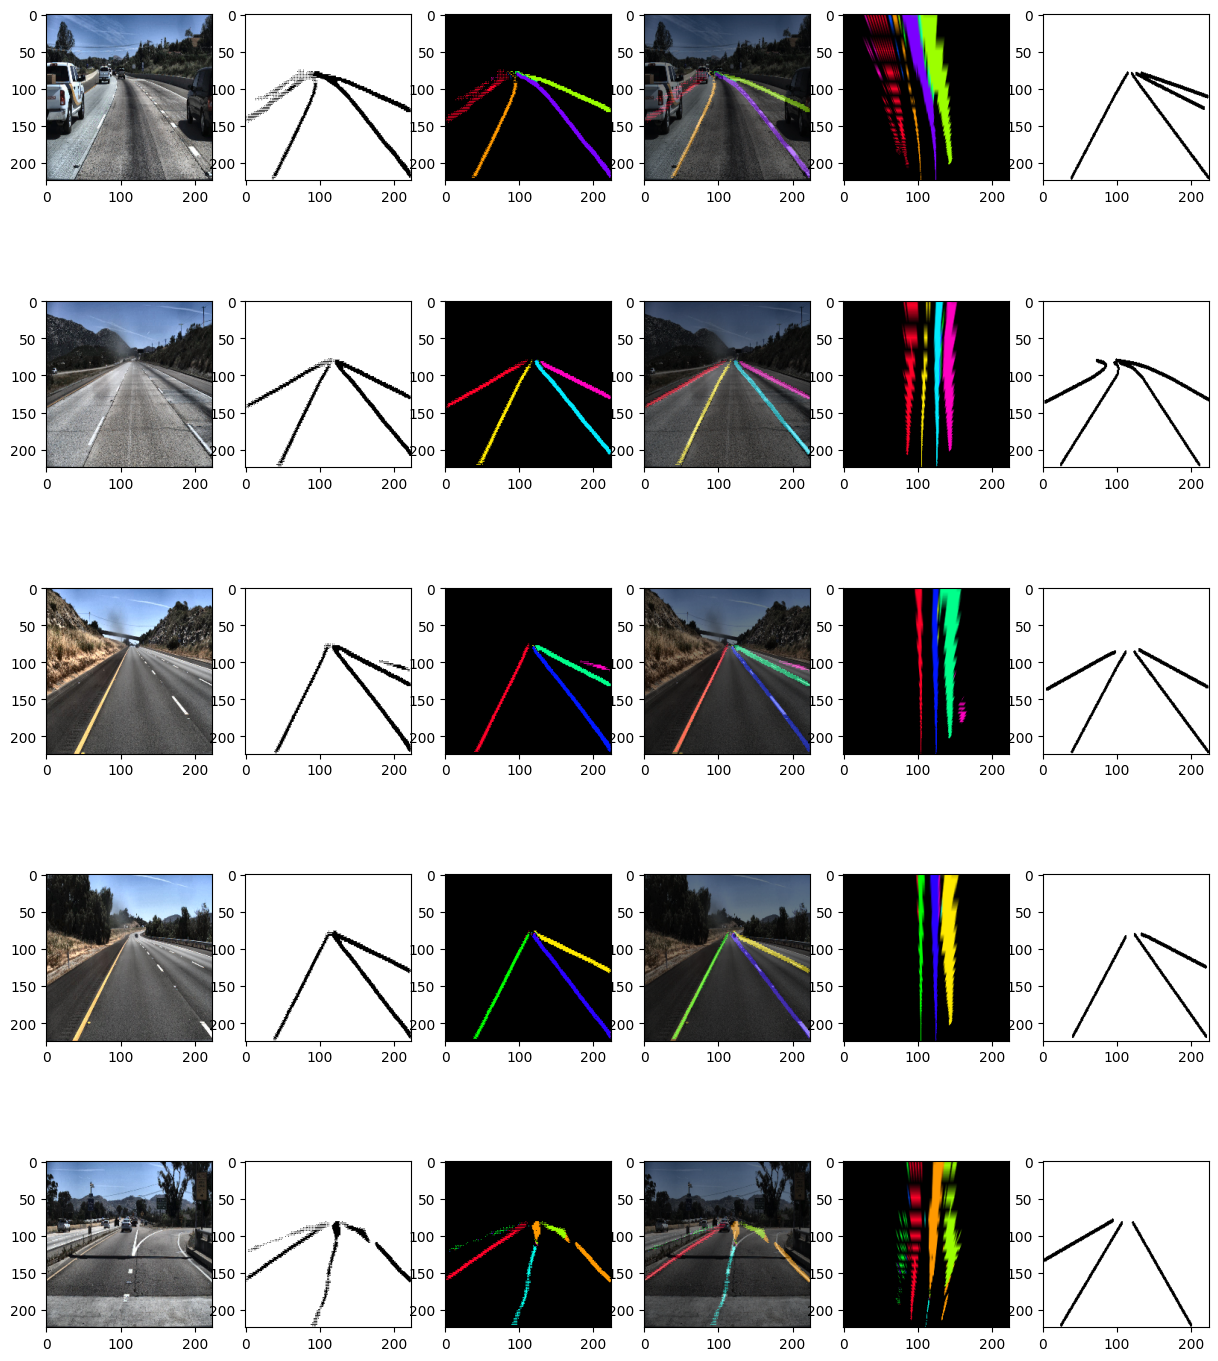

In [4]:
test_model('test1_model_best', model='enet', data_part='test')